In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gate import AddGate, MultiplyGate, DotGate, BiasGate, SigmoidGate, ReluGate, SoftmaxGate

In [2]:
class FullyConnectedLayer(object):
    
    def __init__(self, 
                 prev_dimension, 
                 dimension, 
                 activation_function='relu',  
                 dropout=False, 
                 keep_prob=0.5, 
                 l2_regularization=False, 
                 l2_lambda=0.7, 
                 trainable=True,
                 name=None):
        self.prev_dimension = prev_dimension
        self.dimension = dimension
        self.activation_function = activation_function
        self.dropout = dropout
        self.keep_prob = keep_prob
        self.l2_regularization = l2_regularization
        self.l2_lambda = l2_lambda
        self.trainable = trainable
        self.name = name
        self.creat_computation_graph()
        self.initialize_parameters(prev_dimension, dimension)
        self.initialize_optimizers()
        pass
    
    def creat_computation_graph(self):
        self.dot_gate = DotGate()
        self.bias_gate = BiasGate()
        if self.activation_function == 'relu':
            self.activation_gate = ReluGate()
            pass
        elif self.activation_function == 'sigmoid':
            self.activation_gate = SigmoidGate()
            pass
        elif self.activation_function == 'softmax':
            self.activation_gate = SoftmaxGate()
            pass
        else:
            raise ValueError("no activation function named '" + str(self.activation_function) + "'.")
            pass
        pass
    
    def initialize_parameters(self, prev_dimension, dimension):
        self.parameters = {}
        self.parameters['W'] = np.random.randn(dimension, prev_dimension) * np.sqrt(2/prev_dimension)
        self.parameters['b'] = np.zeros((dimension, 1))
        self.v = {}
        self.v['dW'] = np.zeros((self.parameters['W'].shape[0], self.parameters['W'].shape[1]))
        self.v['db'] = np.zeros((self.parameters['b'].shape[0], self.parameters['b'].shape[1]))
        self.s = {}
        self.s['dW'] = np.zeros((self.parameters['W'].shape[0], self.parameters['W'].shape[1]))
        self.s['db'] = np.zeros((self.parameters['b'].shape[0], self.parameters['b'].shape[1]))
        pass
    
    def initialize_optimizers(self, momentum_beta=0.9, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-8):
        self.momentum_beta = momentum_beta
        self.adam_beta1 = adam_beta1
        self.adam_beta2 = adam_beta2
        self.adam_epsilon = adam_epsilon
        self.adam_t = 0
        pass
        
    def forward_propagation(self, X, predict_mode=False):
        self.D = self.dot_gate.forward(self.parameters['W'], X)
        self.Z = self.bias_gate.forward(self.D, self.parameters['b'])
        self.A = self.activation_gate.forward(self.Z)
        if self.l2_regularization:
            _, m = X.shape
            self.l2_regularization_cost = 1.0/m * self.l2_lambda * np.sum(np.square(self.parameters['W'])) / 2
            pass
        if self.dropout:
            self.Drop = np.random.rand(self.A.shape[0], self.A.shape[1])     
            self.Drop = self.Drop < self.keep_prob
            self.A_dropout = self.A * self.Drop
            self.A_dropout = self.A_dropout / self.keep_prob
            if predict_mode:
                return self.A
            else:
                return self.A_dropout
            pass
        return self.A
    
    def backward_propagation(self, dA):
        self.grads = {}
        self.dA = dA
        if self.dropout: 
            self.dA = dA * self.Drop
            self.dA = self.dA / self.keep_prob
            pass
        self.dZ = self.activation_gate.backward(self.dA)
        self.dD, self.db = self.bias_gate.backward(self.dZ)
        self.dW, self.dA_prev = self.dot_gate.backward(self.dD)
        if self.l2_regularization:
            _, m = dA.shape
            self.dW += self.l2_lambda / m * self.parameters['W']
            pass
        self.grads['dW'] = self.dW
        self.grads['db'] = self.db
        return self.dA_prev
          
    def update_parameters(self, learning_rate, optimizer=None):
        if optimizer=='adam':
            self.adam_t += 1
            v_corrected = {}      
            s_corrected = {}
            self.v["dW"] = self.adam_beta1 * self.v["dW"] + (1 - self.adam_beta1) * self.grads['dW']
            self.v["db"] = self.adam_beta1 * self.v["db"] + (1 - self.adam_beta1) * self.grads['db']
            v_corrected["dW"] = self.v["dW"] / (1 - self.adam_beta1 ** self.adam_t)
            v_corrected["db"] = self.v["db"] / (1 - self.adam_beta1 ** self.adam_t)
            self.s["dW"] = self.adam_beta2 * self.s["dW"] + (1 - self.adam_beta2) * (self.grads['dW'] ** 2)
            self.s["db"] = self.adam_beta2 * self.s["db"] + (1 - self.adam_beta2) * (self.grads['db'] ** 2)
            s_corrected['dW'] = self.s["dW"] / (1 - self.adam_beta2 ** self.adam_t)
            s_corrected['db'] = self.s["db"] / (1 - self.adam_beta2 ** self.adam_t)
            self.parameters['W'] -= learning_rate * v_corrected["dW"] / (np.sqrt(s_corrected["dW"]) + self.adam_epsilon)
            self.parameters['b'] -= learning_rate * v_corrected["db"] / (np.sqrt(s_corrected["db"]) + self.adam_epsilon)
            pass
        elif optimizer=='momentum':
            self.v["dW"] = self.momentum_beta * self.v["dW"] + (1 - self.momentum_beta) * self.grads['dW']
            self.v["db"] = self.momentum_beta * self.v["db"] + (1 - self.momentum_beta) * self.grads['db']
            self.parameters['W'] -= learning_rate * self.v['dW']
            self.parameters['b'] -= learning_rate * self.v['db']  
            pass
        elif optimizer==None:
            self.parameters['W'] -= learning_rate * self.grads['dW']
            self.parameters['b'] -= learning_rate * self.grads['db']  
            pass
        else:
            raise ValueError("no activation function named '" + str(optimizer) + "'.")
            pass
        pass
    
    pass

In [3]:
class DeepNeuralNetwork(object):
    
    def __init__(self, layer_list, dropout=False, keep_prob=0.5, l2_regularization=False, l2_lambda=0.7, name=None):
        self.layer_list = layer_list
        self.dropout = dropout
        self.keep_prob = keep_prob
        self.l2_regularization = l2_regularization
        self.l2_lambda = l2_lambda
        self.name = name
        self.creat_layers()
        pass
    
    def creat_layers(self):
        self.layers = {}
        layer_list = self.layer_list[:]
        self.L = len(layer_list) - 1
        for l in range(1, self.L):
            self.layers['Layer'+str(l)] = FullyConnectedLayer(layer_list[l-1], layer_list[l], activation_function='relu', \
                                                              dropout=self.dropout, keep_prob=self.keep_prob, \
                                                              l2_regularization=self.l2_regularization, l2_lambda=self.l2_lambda)
            pass
        self.layers['Layer'+str(self.L)] = FullyConnectedLayer(layer_list[self.L-1], layer_list[self.L], activation_function='softmax', \
                                                               dropout=False, l2_regularization=self.l2_regularization, 
                                                               l2_lambda=self.l2_lambda)
        pass
            
    def forward_propagation(self, X, predict_mode=False):
        A_prev = X
        for l in range(1, self.L):
            A_prev = self.layers['Layer'+str(l)].forward_propagation(A_prev, predict_mode=predict_mode)
            pass
        self.AL = self.layers['Layer'+str(self.L)].forward_propagation(A_prev, predict_mode=predict_mode)
        return self.AL
    
    def compute_cost(self, Y):
        _, m = Y.shape
        logprobs = -np.multiply(Y, np.log(self.AL))
        cost = 1.0/m * np.nansum(logprobs)
        cost = np.squeeze(cost)
        if self.l2_regularization:
            for l in range(1, self.L):
                cost += self.layers['Layer'+str(l)].l2_regularization_cost
                pass
            pass
        return cost
    
    def backward_propagation(self, Y):
        _, m = Y.shape
        dA = 1.0/m * -np.squeeze((Y/self.AL))
        for l in reversed(range(1, self.L+1)):
            dA = self.layers['Layer'+str(l)].backward_propagation(dA)
            pass
        pass
    
    def update_parameters(self, learning_rate, optimizer=None):
        for l in range(1, self.L+1):
            self.layers['Layer'+str(l)].update_parameters(learning_rate, optimizer)
            pass
        pass
    
    def random_mini_batches(self, X, Y, mini_batch_size = 64, seed = 0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []
        # creat an index list from 0 to m-1
        permutation = list(np.random.permutation(m))
        # random
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation]
        try:
            num_complete_mini_batches = math.floor(m/mini_batch_size)
            pass
        except:
            import math
            num_complete_mini_batches = math.floor(m/mini_batch_size)
            pass
        # complete mini batches
        for k in range(0, num_complete_mini_batches):
            mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
            mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
            pass
        # res mini batch
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, num_complete_mini_batches * mini_batch_size:]
            mini_batch_Y = shuffled_Y[:, num_complete_mini_batches * mini_batch_size:]
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
            pass
        return mini_batches
    
    def train(self, X, Y, learning_rate=0.0001, optimizer=None, epoches=1000):
        self.mini_batch_costs = []
        self.costs = []
        seed = 0
        for epoch in range(epoches):
            cost = 0.0
            seed = seed + 1
            mini_batches = self.random_mini_batches(X, Y, seed=seed)
            for mini_batch in mini_batches:
                (minibatch_X, minibatch_Y) = mini_batch
                _, m_mini_batch = minibatch_X.shape
                AL = self.forward_propagation(minibatch_X)
                mini_batch_cost = self.compute_cost(minibatch_Y)
                self.mini_batch_costs.append(mini_batch_cost)
                cost += m_mini_batch * mini_batch_cost
                self.backward_propagation(minibatch_Y)
                self.update_parameters(learning_rate=learning_rate, optimizer=optimizer)
                pass
            _, m = X.shape
            cost = cost / m
            self.costs.append(cost)
            if epoch%500 == 0 :
                print('Cost after epoch ' + str(epoch) + ': ' + str(cost))
                pass
            pass
        pass
    
    def plot_costs(self):
        plt.plot(self.mini_batch_costs)
        plt.title('mini batch costs')
        plt.show()
        plt.plot(self.costs)
        plt.title('costs')
        plt.show()
        pass
    
    def predict(self, X):
        AL = self.forward_propagation(X, predict_mode=True)
        predictions = np.squeeze(np.argmax(AL, axis=0))
        return predictions
    
    def plot_model_boundary(self, model, X, y):
        # Set min and max values and give it some padding
        x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
        y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
        h = 0.01
        # Generate a grid of points with distance h between them
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        # Predict the function value for the whole grid
        Z = model(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # Plot the contour and training examples
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
        plt.show()
        pass
    
    def plot_decision_boundary(self, X, Y):
        n, m = Y.shape
        if n==1:
            y = Y[:]
            self.plot_model_boundary(lambda x: self.predict(x.T), X, np.squeeze(y))
            pass
        else:
            y = []
            for i in range(n):
                y.append([i])
                pass
            y = np.array(y)
            y = y * Y
            y = np.squeeze(np.sum(y, axis=0))
            self.plot_model_boundary(lambda x: self.predict(x.T), X, np.squeeze(y))
            pass
        pass
    
    pass         

In [4]:
np.random.seed(1)

In [5]:
def load_dataset():
    np.random.seed(1)
    m = 800 # number of examples
    C = 4
    N = int(m/C) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 7 # maximum ray of the flower
    for j in range(C):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(3*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t+j*3.14/2), r*np.cos(t+j*3.14/2)]
        Y[ix] = j
        pass 
    X = X.T
    Y = Y.T
    return X, Y

In [6]:
X, Y = load_dataset()

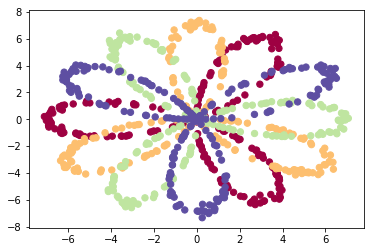

In [7]:
plt.scatter(X[0, :], X[1, :], c=Y[0, :], s=40, cmap=plt.cm.Spectral)
plt.show()

In [8]:
print(X.shape)
print(Y.shape)

(2, 800)
(1, 800)


In [9]:
n_classes = np.max(np.squeeze(Y)) + 1
Y_softmax = np.eye(n_classes)[np.squeeze(Y)]
Y_softmax = Y_softmax.T
print(Y_softmax)

[[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


In [10]:
print(Y_softmax.shape)

(4, 800)


In [11]:
dnn = DeepNeuralNetwork([2, 36, 18, 4], dropout=False, keep_prob=0.5, l2_regularization=True, l2_lambda=0.18)

In [12]:
dnn.train(X, Y_softmax, learning_rate=0.01, optimizer='adam', epoches=10000)

Cost after epoch 0: 3.0381253982848198
Cost after epoch 500: 0.5020739667495384
Cost after epoch 1000: 0.5065257715375975
Cost after epoch 1500: 0.47108750519084874
Cost after epoch 2000: 0.46509950647578596
Cost after epoch 2500: 0.47589710083973846
Cost after epoch 3000: 0.4724208162981288
Cost after epoch 3500: 0.4566728272026664
Cost after epoch 4000: 0.43213473926650875
Cost after epoch 4500: 0.4479885428343325
Cost after epoch 5000: 0.4206239710403188
Cost after epoch 5500: 0.4332148083195952
Cost after epoch 6000: 0.4233795408110991
Cost after epoch 6500: 0.4411544357884318
Cost after epoch 7000: 0.42657289008899957
Cost after epoch 7500: 0.4563668221772324
Cost after epoch 8000: 0.4229954384679043
Cost after epoch 8500: 0.4486134875637703
Cost after epoch 9000: 0.41562468052113033
Cost after epoch 9500: 0.44875641648594594


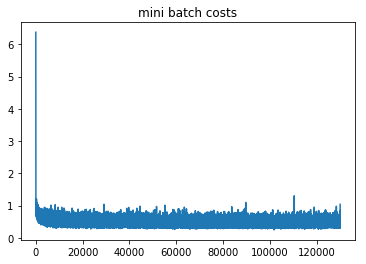

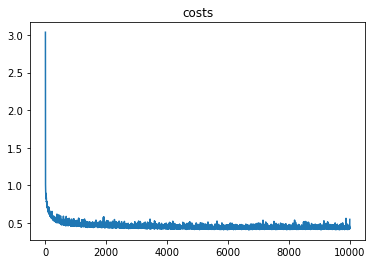

In [13]:
dnn.plot_costs()

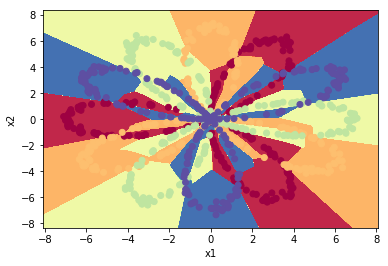

In [14]:
dnn.plot_decision_boundary(X, Y_softmax)

In [15]:
import sklearn
import sklearn.datasets
def load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y

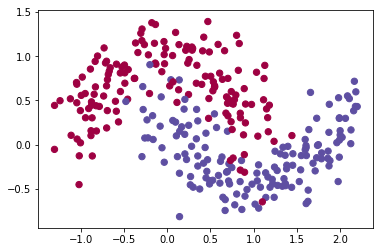

In [16]:
train_X, train_Y = load_dataset()
plt.show()

In [17]:
n_classes = np.max(np.squeeze(train_Y)) + 1
train_Y_softmax = np.eye(n_classes)[np.squeeze(train_Y)]
train_Y_softmax = train_Y_softmax.T

In [18]:
a = DeepNeuralNetwork([2, 12, 5, 2], dropout=False, keep_prob=0.5, l2_regularization=False, l2_lambda=0.18)

In [19]:
a.train(train_X, train_Y_softmax, learning_rate = 0.0007, epoches = 10000)

Cost after epoch 0: 0.7438195555395053
Cost after epoch 500: 0.5034355617812378
Cost after epoch 1000: 0.4357255965115411
Cost after epoch 1500: 0.39477906801200174
Cost after epoch 2000: 0.36908882225602024
Cost after epoch 2500: 0.35175107708500514
Cost after epoch 3000: 0.33858560690683503
Cost after epoch 3500: 0.32834450470314286
Cost after epoch 4000: 0.3205500066857984
Cost after epoch 4500: 0.31423437426705075
Cost after epoch 5000: 0.3089381372097613
Cost after epoch 5500: 0.3042918260307399
Cost after epoch 6000: 0.3000998458215821
Cost after epoch 6500: 0.2962684149315806
Cost after epoch 7000: 0.29274359637758535
Cost after epoch 7500: 0.28937186659908615
Cost after epoch 8000: 0.28614893870929015
Cost after epoch 8500: 0.28305406110559755
Cost after epoch 9000: 0.27991784888858573
Cost after epoch 9500: 0.27672218810616006


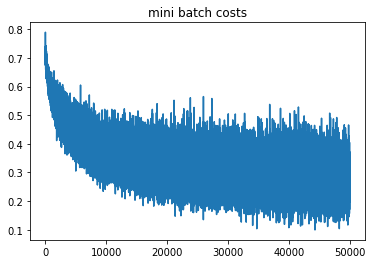

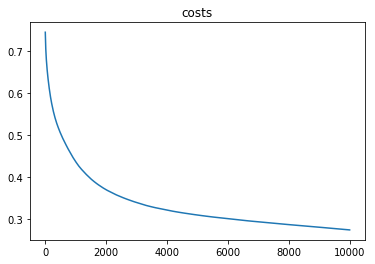

In [20]:
a.plot_costs()

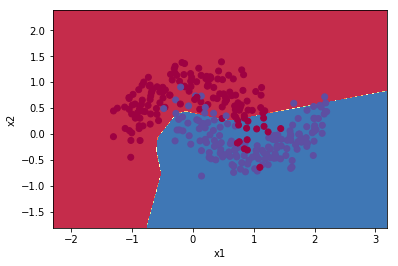

In [21]:
a.plot_decision_boundary(train_X, train_Y_softmax)

In [22]:
b = DeepNeuralNetwork([2, 12, 5, 2], dropout=False, keep_prob=0.5, l2_regularization=False, l2_lambda=0.18)

In [23]:
b.train(train_X, train_Y_softmax, learning_rate = 0.0007, optimizer='momentum', epoches = 10000)

Cost after epoch 0: 0.5822871268131876
Cost after epoch 500: 0.3906268670130191
Cost after epoch 1000: 0.3713593407271371
Cost after epoch 1500: 0.3518870580551023
Cost after epoch 2000: 0.33212038113569586
Cost after epoch 2500: 0.3125541653790623
Cost after epoch 3000: 0.2960254185112034
Cost after epoch 3500: 0.280312480857612
Cost after epoch 4000: 0.2671629529195178
Cost after epoch 4500: 0.25823888259380257
Cost after epoch 5000: 0.25202734666934795
Cost after epoch 5500: 0.24575669503381534
Cost after epoch 6000: 0.23892692008182598
Cost after epoch 6500: 0.232038709451547
Cost after epoch 7000: 0.22593481842861687
Cost after epoch 7500: 0.21997488801436635
Cost after epoch 8000: 0.21452962811729046
Cost after epoch 8500: 0.21014479048421303
Cost after epoch 9000: 0.20633674195624005
Cost after epoch 9500: 0.20289161863489635


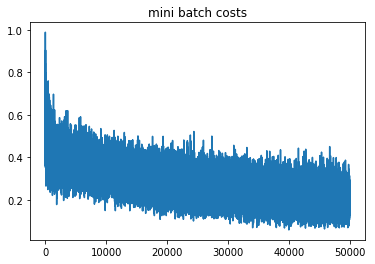

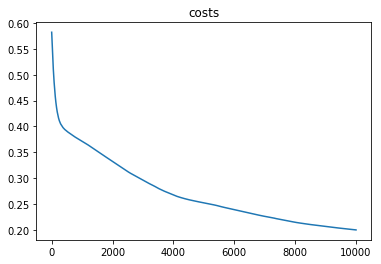

In [24]:
b.plot_costs()

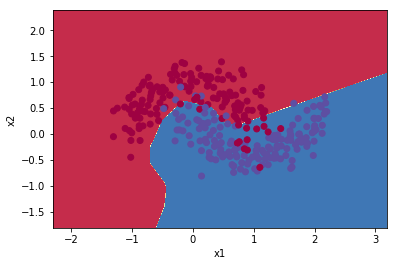

In [25]:
b.plot_decision_boundary(train_X, train_Y_softmax)

In [26]:
c = DeepNeuralNetwork([2, 12, 5, 2], dropout=False, keep_prob=0.5, l2_regularization=False, l2_lambda=0.18)

In [27]:
c.train(train_X, train_Y_softmax, learning_rate = 0.0007, optimizer='adam', epoches = 10000)

Cost after epoch 0: 0.5783764293527147
Cost after epoch 500: 0.152781236936246
Cost after epoch 1000: 0.12456249900306758
Cost after epoch 1500: 0.1141462220968279
Cost after epoch 2000: 0.10975427351496184
Cost after epoch 2500: 0.10669531225885942
Cost after epoch 3000: 0.10321974466457774
Cost after epoch 3500: 0.10111764497967662
Cost after epoch 4000: 0.0984443437115142
Cost after epoch 4500: 0.09664525662005106
Cost after epoch 5000: 0.09522743835862539
Cost after epoch 5500: 0.09289456504850072
Cost after epoch 6000: 0.08829418822891938
Cost after epoch 6500: 0.08484819895904504
Cost after epoch 7000: 0.08190040131572862
Cost after epoch 7500: 0.07902325259990935
Cost after epoch 8000: 0.07662818010818084
Cost after epoch 8500: 0.07457285466510158
Cost after epoch 9000: 0.07217006959651145
Cost after epoch 9500: 0.07050806134779809


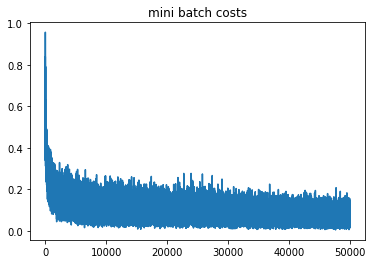

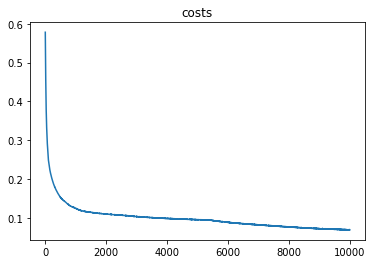

In [28]:
c.plot_costs()

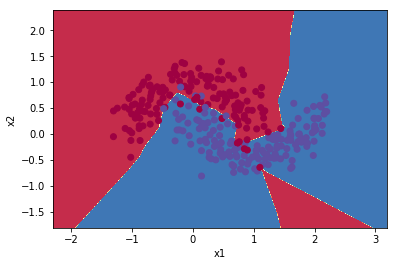

In [29]:
c.plot_decision_boundary(train_X, train_Y_softmax)

In [30]:
d = DeepNeuralNetwork([2, 12, 5, 2], dropout=False, keep_prob=0.5, l2_regularization=True, l2_lambda=0.2)

In [31]:
d.train(train_X, train_Y_softmax, learning_rate = 0.0007, optimizer='adam', epoches = 10000)

Cost after epoch 0: 0.648129806302106
Cost after epoch 500: 0.2092641129758169
Cost after epoch 1000: 0.17713571471707426
Cost after epoch 1500: 0.17107263552752183
Cost after epoch 2000: 0.16839670173960097
Cost after epoch 2500: 0.1664737338612508
Cost after epoch 3000: 0.16557730366365245
Cost after epoch 3500: 0.16545499155396784
Cost after epoch 4000: 0.16416732683924015
Cost after epoch 4500: 0.16375169681754556
Cost after epoch 5000: 0.16348097121131602
Cost after epoch 5500: 0.16322091991037427
Cost after epoch 6000: 0.16314212394307717
Cost after epoch 6500: 0.16298606318710204
Cost after epoch 7000: 0.1628722526811021
Cost after epoch 7500: 0.16293453062531757
Cost after epoch 8000: 0.16284696885302527
Cost after epoch 8500: 0.1630793184152815
Cost after epoch 9000: 0.16273607012979224
Cost after epoch 9500: 0.16262909785577462


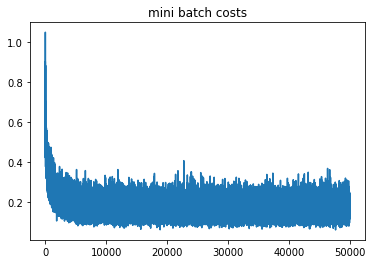

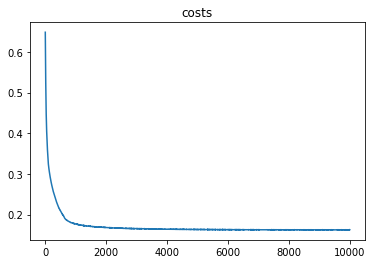

In [32]:
d.plot_costs()

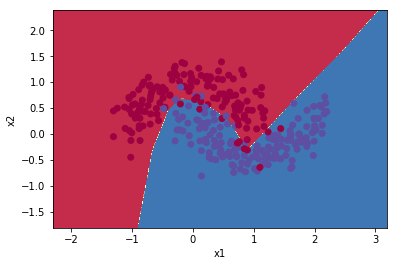

In [33]:
d.plot_decision_boundary(train_X, train_Y_softmax)

In [34]:
e = DeepNeuralNetwork([2, 12, 5, 2], dropout=True, keep_prob=0.7, l2_regularization=False, l2_lambda=0.2)

In [35]:
e.train(train_X, train_Y_softmax, learning_rate = 0.0007, optimizer='adam', epoches = 10000)

Cost after epoch 0: 0.7807854455749706
Cost after epoch 500: 0.3480550247929833
Cost after epoch 1000: 0.3145911540374277
Cost after epoch 1500: 0.251774124649607
Cost after epoch 2000: 0.2503281695494049
Cost after epoch 2500: 0.2368536210417698
Cost after epoch 3000: 0.22682073867000715
Cost after epoch 3500: 0.2432573286614826
Cost after epoch 4000: 0.25358424544045477
Cost after epoch 4500: 0.21055112786319183
Cost after epoch 5000: 0.22718402182219394
Cost after epoch 5500: 0.26866703811694176
Cost after epoch 6000: 0.2093245388308414
Cost after epoch 6500: 0.20365998559494003
Cost after epoch 7000: 0.21711853320880603
Cost after epoch 7500: 0.23377773506126318
Cost after epoch 8000: 0.27516059359521944
Cost after epoch 8500: 0.20768965199851516
Cost after epoch 9000: 0.21453323446325007
Cost after epoch 9500: 0.23339642200906993


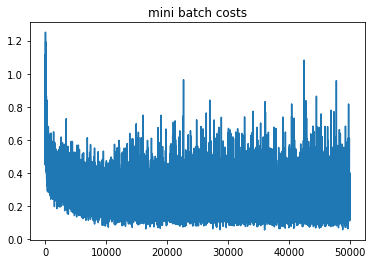

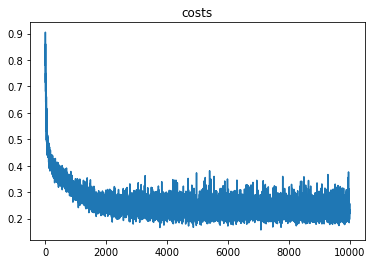

In [36]:
e.plot_costs()

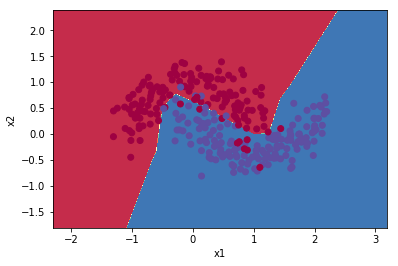

In [37]:
e.plot_decision_boundary(train_X, train_Y_softmax)